# Extract Resistances (Rs and R1) from HPPC and GITT tests

Created 11/6/22

Authors: Clement Wong

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For HPPC

### Load Data

In [2]:
HPPC_file ='HPPC_drill_packs.csv'
HPPC_df = pd.read_csv(HPPC_file)

In [3]:
HPPC_df.head()

,Unnamed: 0,elapsed time,Pack Current FB,qCct,Voltage1,Voltage2,Voltage3,Voltage4,Voltage5,soc
0,0,0.0,-0.722,6.0,4.190494,4.197848,4.202481,4.201134,4.199902,1.0
1,1,0.1,-1.500,6.0,4.179817,4.189735,4.191938,4.191270,4.188257,1.0
2,2,0.2,-1.500,6.0,4.179590,4.189503,4.191671,4.190978,4.188015,1.0
3,3,0.3,-1.500,6.0,4.179379,4.189277,4.191503,4.190820,4.187779,1.0
4,4,0.4,-1.500,6.0,4.179184,4.189120,4.191316,4.190657,4.187609,1.0


In [4]:
voltage_column = 'Voltage1'
current_column = 'Pack Current FB'
soc_column = 'soc'
time_column = 'elapsed time'

voltage_list = HPPC_df[voltage_column].tolist()
current_list= HPPC_df[current_column ].tolist()
soc_list= HPPC_df[soc_column].tolist()
time_list = HPPC_df[time_column].tolist()

### Extract Resistances (Rs, R1, OCV) from HPPC with their respective SOC values

In [5]:
def resistance_HPPC(voltage_list, current_list, soc_list, time_list, current_step, tol = .05, charge = True): 
    d = {'Voltage': voltage_list, 'Current': current_list, 'SOC': soc_list, 'Time': time_list}
    
    df = pd.DataFrame(data=d)
    df ['current_diff'] = [0] +np.diff(df['Current']).tolist()
    
    
    if (charge):
        t_f = df[(df['current_diff']<-(current_step-current_step*tol))& (df['current_diff']>-(current_step+current_step*tol))].index
    else:
        t_f = df[(df['current_diff']>(current_step - current_step*tol)) & (df['current_diff']<(current_step + current_step*tol)) ].index                   
    
    t_i = t_f-1
    
    #indices for t_relaxed
    t_relaxed = list()
    for t_f_index in t_f: 
        df_after_pulse = df.loc[t_f_index+1: ]    
        t_relaxed = t_relaxed +[df_after_pulse[abs(df_after_pulse['current_diff'])> 0].index[0]-1]
        
    delta_V_Rs =np.array(df.loc[t_f, 'Voltage'])-np.array(df.loc[t_i, 'Voltage'])
    delta_I_Rs = np.array(df.loc[t_f, 'Current'])-np.array(df.loc[t_i, 'Current']) 
    Rs = delta_V_Rs/delta_I_Rs
    SOC_Rs = df.loc[t_f, 'SOC']
    
    
    
##   Plots for Debugging 
    fig, ax = plt.subplots()
    ax.plot(df['Time'], df['Current'])
    ax.scatter(df.loc[t_i, 'Time'], df.loc[t_i, 'Current'], color = 'g')
    ax.scatter(df.loc[t_f, 'Time'], df.loc[t_f, 'Current'], color = 'm')
    ax.scatter(df.loc[t_relaxed , 'Time'], df.loc[t_relaxed , 'Current'], color = 'r')
    ax.set_xlabel ('Time (s)')
    ax.set_ylabel('Current(A)')
##   Plots for Debugging
    
    delta_V_Rc =np.array(df.loc[t_relaxed, 'Voltage'])-np.array(df.loc[t_i, 'Voltage'])
    delta_I_Rc= np.array(df.loc[t_relaxed, 'Current'])-np.array(df.loc[t_i, 'Current'])
    Rc = delta_V_Rc/delta_I_Rc
    SOC_Rc = df.loc[t_relaxed, 'SOC']
    
    
    
    OCV = df.loc[t_relaxed, 'Voltage']
    SOC_OCV  = df.loc[t_relaxed, 'SOC']

    
    return (SOC_Rs, Rs, SOC_Rc, Rc, SOC_OCV, OCV)



    
    


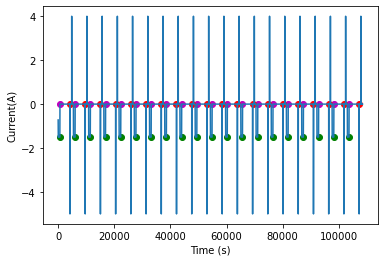

In [6]:
SOC_Rs, Rs, SOC_Rc, Rc, SOC_OCV, OCV = resistance_HPPC(voltage_list, current_list, soc_list, time_list,  1.5, tol = .05, charge= False)

# Plots

Text(0, 0.5, 'Rs ($\\Omega$)')

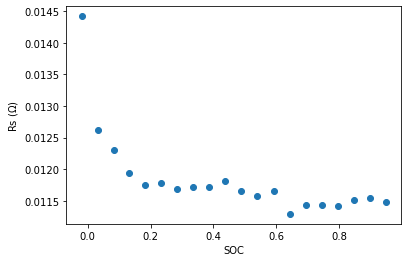

In [7]:
fig, ax = plt.subplots()
ax.scatter(SOC_Rs, Rs)
ax.set_xlabel('SOC')
ax.set_ylabel('Rs ($\Omega$)')

Text(0, 0.5, 'R1 ($\\Omega$)')

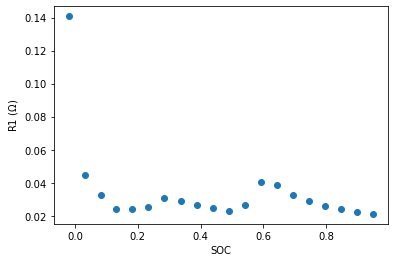

In [8]:
fig, ax = plt.subplots()
ax.scatter(SOC_Rc, Rc)
ax.set_xlabel('SOC')
ax.set_ylabel('R1 ($\Omega$)')

Text(0, 0.5, 'OCV')

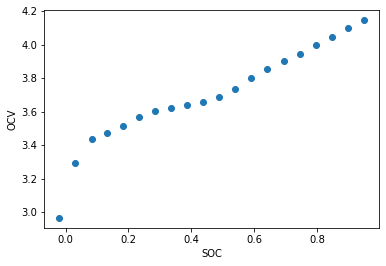

In [9]:
fig, ax = plt.subplots()
ax.scatter(SOC_OCV, OCV )
ax.set_xlabel('SOC')
ax.set_ylabel('OCV')

# For GITT (basically same algorithm & code as HPPC but different variables)

### Load Data

In [10]:
GITT_charge ='GITT_charge.csv'
GITT_discharge = 'GITT_discharge.csv'
GITT_file = GITT_charge
GITT_df = pd.read_csv(GITT_file)

In [11]:
GITT_df.head()

,Unnamed: 0,mode,ox/red,error,control changes,Ns changes,counter inc.,Ns,I Range,time/s,...,Capacity/mA.h,Efficiency/%,control/V,control/mA,cycle number,P/W,R/Ohm,Unnamed: 33,current_diff,y
0,12,1,0,0,0,0,0,1,116,120.016006,...,1.112703e-07,0.0,0.0,0.2,0.0,0.000550,13715.040,NaN,0.200287,1.000000
1,13,1,1,0,0,1,0,1,116,120.018006,...,2.224968e-07,0.0,0.0,0.2,0.0,0.000550,13722.797,NaN,-0.000079,1.000000
2,14,1,1,0,0,0,0,1,116,120.032006,...,1.001159e-06,0.0,0.0,0.2,0.0,0.000550,13735.532,NaN,-0.000039,1.000000
3,15,1,1,0,0,0,0,1,116,120.052006,...,2.113523e-06,0.0,0.0,0.2,0.0,0.000551,13733.604,NaN,0.000177,1.000000
4,16,1,1,0,0,0,0,1,116,120.080006,...,3.671011e-06,0.0,0.0,0.2,0.0,0.000552,13741.125,NaN,0.000039,0.999999


In [12]:
voltage_column ='Ecell/V'
current_column = 'I/mA' 
y_column = 'y' 
time_column = 'time/s'

voltage_list = GITT_df[voltage_column].tolist()
current_list= (GITT_df[current_column ]/1000).tolist() #converted mA to A
y_list= GITT_df[y_column].tolist()
time_list= GITT_df[time_column].tolist()

### Extract Resistances (Rs, R1, OCV) from GITT with their respective y values

In [13]:
def resistance_GITT(voltage_list, current_list, y_list, time_list, current_step, tol = .05, charge = True): 
    d = {'Voltage': voltage_list, 'Current': current_list, 'y': y_list, 'Time': time_list}
    
    df = pd.DataFrame(data=d)
    df ['current_diff'] = [0] +np.diff(df['Current']).tolist()
    
    
    if (charge):
        t_f = df[(df['current_diff']<-(current_step-current_step*tol))& (df['current_diff']>-(current_step+current_step*tol))].index
    else:
        t_f = df[(df['current_diff']>(current_step - current_step*tol)) & (df['current_diff']<(current_step + current_step*tol)) ].index                   
    
    t_i = t_f-1
    
    #indices for t_relaxed
    t_relaxed = list()
    for t_f_index in t_f: 
        df_after_pulse = df.loc[t_f_index+1: ]    
        t_relaxed = t_relaxed +[df_after_pulse[abs(df_after_pulse['current_diff'])> 0].index[0]-1]
        
    delta_V_Rs =np.array(df.loc[t_f, 'Voltage'])-np.array(df.loc[t_i, 'Voltage'])
    delta_I_Rs = np.array(df.loc[t_f, 'Current'])-np.array(df.loc[t_i, 'Current']) 
    Rs = delta_V_Rs/delta_I_Rs
    y_Rs = df.loc[t_f, 'y']
    
    
    
##   Plots for Debugging 
    fig, ax = plt.subplots()
    ax.plot(df['Time'], df['Current'])
    ax.scatter(df.loc[t_i, 'Time'], df.loc[t_i, 'Current'], color = 'g')
    ax.scatter(df.loc[t_f, 'Time'], df.loc[t_f, 'Current'], color = 'm')
    ax.scatter(df.loc[t_relaxed , 'Time'], df.loc[t_relaxed , 'Current'], color = 'r')
    ax.set_xlabel ('Time (s)')
    ax.set_ylabel('Current (A)')
##   Plots for Debugging
    
    delta_V_Rc =np.array(df.loc[t_relaxed, 'Voltage'])-np.array(df.loc[t_i, 'Voltage'])
    delta_I_Rc= np.array(df.loc[t_relaxed, 'Current'])-np.array(df.loc[t_i, 'Current'])
    Rc = delta_V_Rc/delta_I_Rc
    y_Rc = df.loc[t_relaxed, 'y']
    
    
    
    OCV = df.loc[t_relaxed, 'Voltage']
    y_OCV  = df.loc[t_relaxed, 'y']

    
    return (y_Rs, Rs, y_Rc, Rc, y_OCV, OCV)



    
    


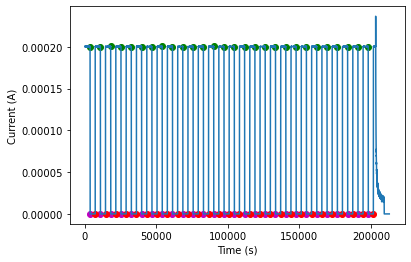

In [14]:
y_Rs, Rs, y_Rc, Rc, y_OCV, OCV = resistance_GITT(voltage_list, current_list, y_list, time_list,  .2/1000, tol = .05, charge= True)

# Plots

Text(0, 0.5, 'Rs ($\\Omega$)')

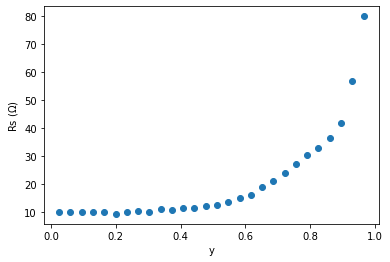

In [15]:
fig, ax = plt.subplots()
ax.scatter(y_Rs, Rs)
ax.set_xlabel('y')
ax.set_ylabel('Rs ($\Omega$)')

Text(0, 0.5, 'R1 ($\\Omega$)')

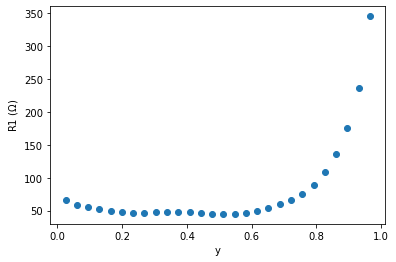

In [16]:
fig, ax = plt.subplots()
ax.scatter(y_Rc, Rc)
ax.set_xlabel('y')
ax.set_ylabel('R1 ($\Omega$)')

Text(0, 0.5, 'OCV ')

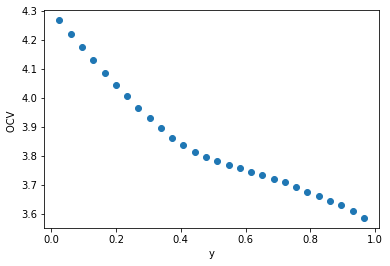

In [17]:
fig, ax = plt.subplots()
ax.scatter(y_OCV, OCV )
ax.set_xlabel('y')
ax.set_ylabel('OCV ')